In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast

from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, average_precision_score
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

In [68]:
# Load data
# This assumes data is in a DataFrame called df with 'NDVI', 'NBR' as columns and 'label' as target column

data = pd.read_csv('../dataset_tables/final_dataset.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      251 non-null    object
 1   split   251 non-null    object
 2   Label   251 non-null    bool  
 3   NDVI    251 non-null    object
 4   NBR     251 non-null    object
 5   NDWI    251 non-null    object
 6   NDBI    251 non-null    object
 7   RGB     251 non-null    object
dtypes: bool(1), object(7)
memory usage: 14.1+ KB


In [69]:
# Randomly drop 190 rows where label is 0
data = data.drop(data[data.Label == 0].sample(190, random_state=1).index)

In [70]:
# Function to convert string to list
def convert_string_to_list(item):
    if isinstance(item, (int, float)):
        return [item]
    s = str(item)
    s = s.replace('nan', '0')
    lst = ast.literal_eval(s)
    return lst

# Apply conversion function to relevant columns
data['NDVI'] = data['NDVI'].apply(lambda x: convert_string_to_list(x))
data['NBR'] = data['NBR'].apply(lambda x: convert_string_to_list(x))
data['NDWI'] = data['NDWI'].apply(lambda x: convert_string_to_list(x))
data['NDBI'] = data['NDBI'].apply(lambda x: convert_string_to_list(x))

In [71]:
# Identify training data
# In datafram, if column split == "train" or "val" then it is training data
# Otherwise it is test data
train_data = data[(data['split'] == 'train') | (data['split'] == 'val')]
test_data = data[data['split'] == 'test']

X_train = np.array([np.ravel(ndvi + ndwi + nbr + ndbi)
    for ndvi, ndwi, nbr, ndbi in zip(train_data['NDVI'], train_data['NDWI'], train_data['NBR'], train_data['NDBI'])])
X_train = np.nan_to_num(X_train)
y_train = train_data['Label'].values

X_test = np.array([np.ravel(ndvi + ndwi + nbr + ndbi)
    for ndvi, ndwi, nbr, ndbi in zip(test_data['NDVI'], test_data['NDWI'], test_data['NBR'], test_data['NDBI'])])
X_test = np.nan_to_num(X_test)
y_test = test_data['Label'].values

In [72]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [73]:
# Define parameter grid for SVM
C_range = np.logspace(-3, 3, 7)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)

In [74]:
# Perform grid search with cross-validation
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=cv)
grid.fit(X_train_resampled, y_train_resampled)

print("The best parameters are %s with a score of %0.2f" % (grid.best_params_, grid.best_score_))


The best parameters are {'C': 10.0, 'gamma': 0.0001} with a score of 0.94


In [75]:
# Initialize SVM model with best parameters
best_params = grid.best_params_
model = svm.SVC(kernel='rbf', gamma=best_params['gamma'], C=best_params['C']).fit(X_train, y_train)

In [76]:
# Evaluate model on test set
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.6250
Precision: 0.6250
Recall: 1.0000
F1-score: 0.7692

Classification Report:
              precision    recall  f1-score   support

       False       0.00      0.00      0.00         6
        True       0.62      1.00      0.77        10

    accuracy                           0.62        16
   macro avg       0.31      0.50      0.38        16
weighted avg       0.39      0.62      0.48        16


Confusion Matrix:
[[ 0  6]
 [ 0 10]]


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

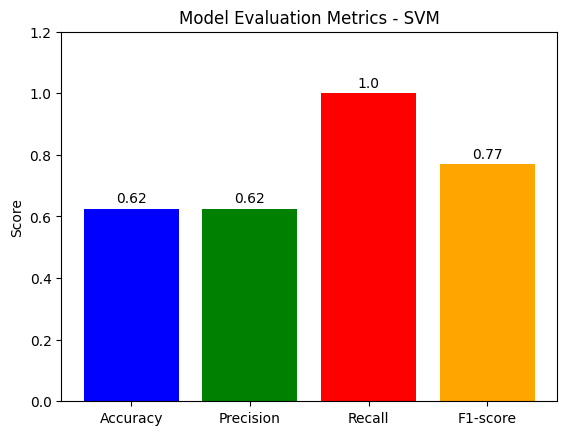

In [77]:
# Visualize model evaluation metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
values = [accuracy, precision, recall, f1]

bars = plt.bar(metrics, values, color=['blue', 'green', 'red', 'orange'])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

plt.ylabel('Score')
plt.title('Model Evaluation Metrics - SVM')
plt.ylim(0, 1.2)
plt.show()